In [1]:
import os
from glob import glob

import re
import nltk
import numpy as np
from numpy.linalg import norm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles
import seaborn as sns

import spacy
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

plt.rcParams['figure.figsize'] = (17,7)
sns.set_style('darkgrid')

nltk.download("all-nltk")

[nltk_data] Downloading collection 'all-nltk'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/akeresh/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/akeresh/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/akeresh/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/akeresh/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /home/akeresh/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to
[nltk_

True

## Create datasets

In [3]:
def read_txt(path_to_txt):
    with open(path_to_txt, "r") as fin:
        fout = fin.readlines()
    return fout[0]

def create_df(path_to_folder: str, pattern: str = '**/*.txt'):
    labels = []
    texts = []
    for path in glob(os.path.join(path_to_folder, pattern)):
        label = os.path.dirname(path).split("/")[-1]
        text = read_txt(path)
        labels.append(label)
        texts.append(text)
    
    df = pd.DataFrame({"text": texts, "label": labels})
    return df

In [4]:
X_val = create_df("data/train/")

In [5]:
val = create_df("data/validat/")

In [6]:
test = pd.DataFrame({"text": [read_txt(i) for i in glob("data/test/*")]})

In [7]:
X_val.to_csv("train.csv", index=False)
val.to_csv("val.csv", index=False)
test.to_csv("test.csv", index=False)

## EDA

### Basic statistics

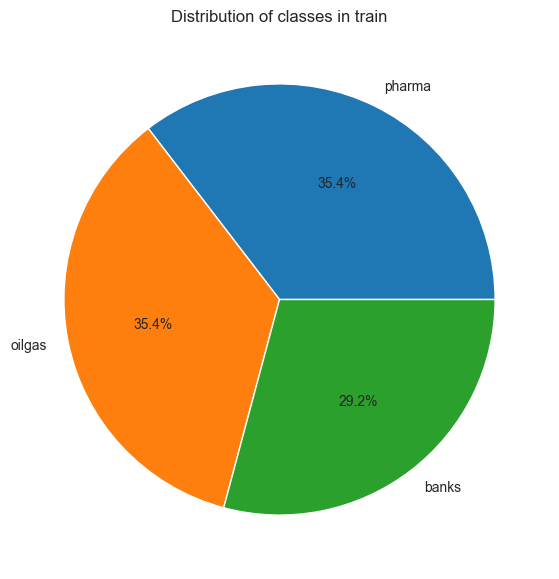

In [8]:
plt.pie(X_val.label.value_counts(), labels=X_val.label.unique().tolist(), autopct='%1.1f%%')
plt.title('Distribution of classes in train');

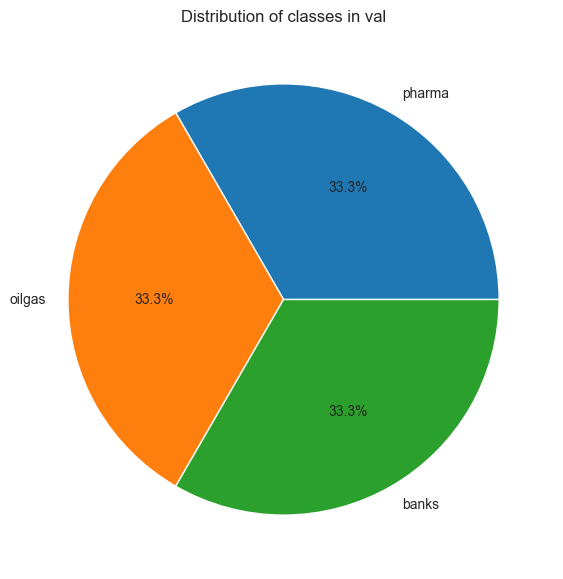

In [9]:
plt.pie(val.label.value_counts(), labels=val.label.unique().tolist(), autopct='%1.1f%%')
plt.title('Distribution of classes in val');

In [10]:
X_val["length"] = X_val["text"].str.len()

[Text(0.5, 1.0, 'Text lenght')]

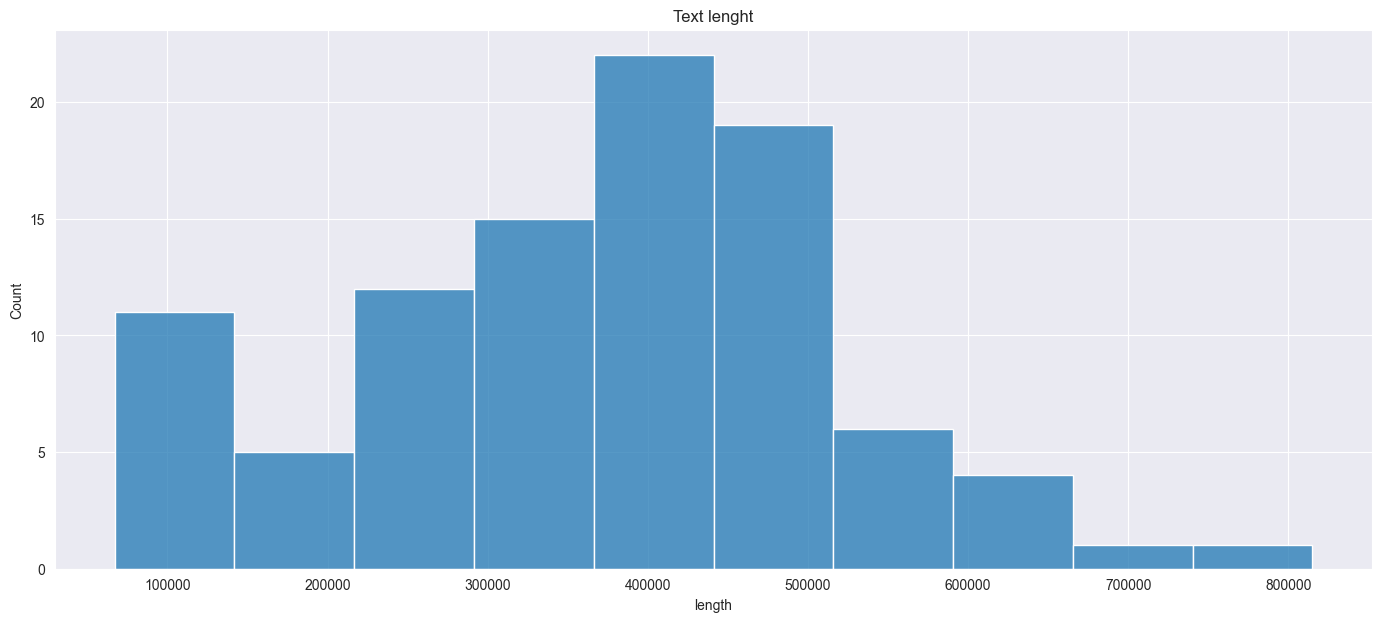

In [11]:
sns.histplot(X_val["length"]).set(title='Text lenght')

In [12]:
X_val["word_count"] = X_val["text"].str.split().str.len()

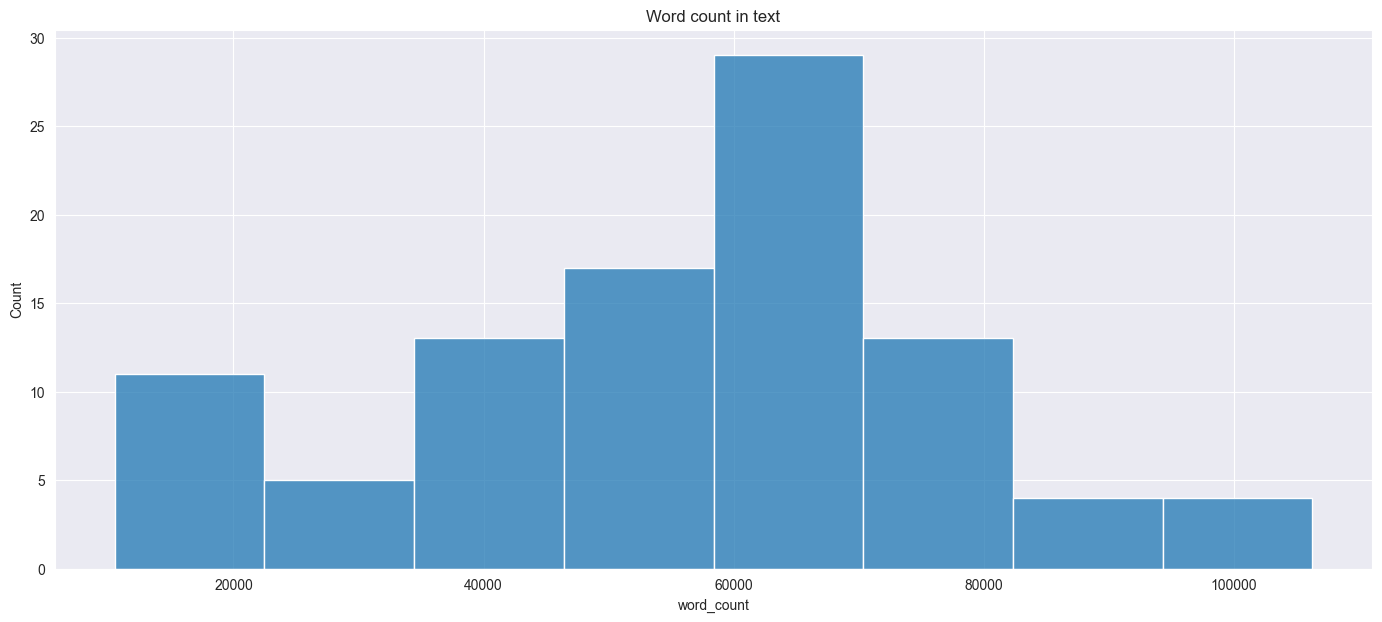

In [13]:
sns.histplot(X_val["word_count"]).set(title='Word count in text');

In [14]:
X_val['mean_word_length'] = X_val["text"].map(lambda rev: np.mean([len(word) for word in rev.split()]))

[Text(0.5, 1.0, 'Mean word lenght')]

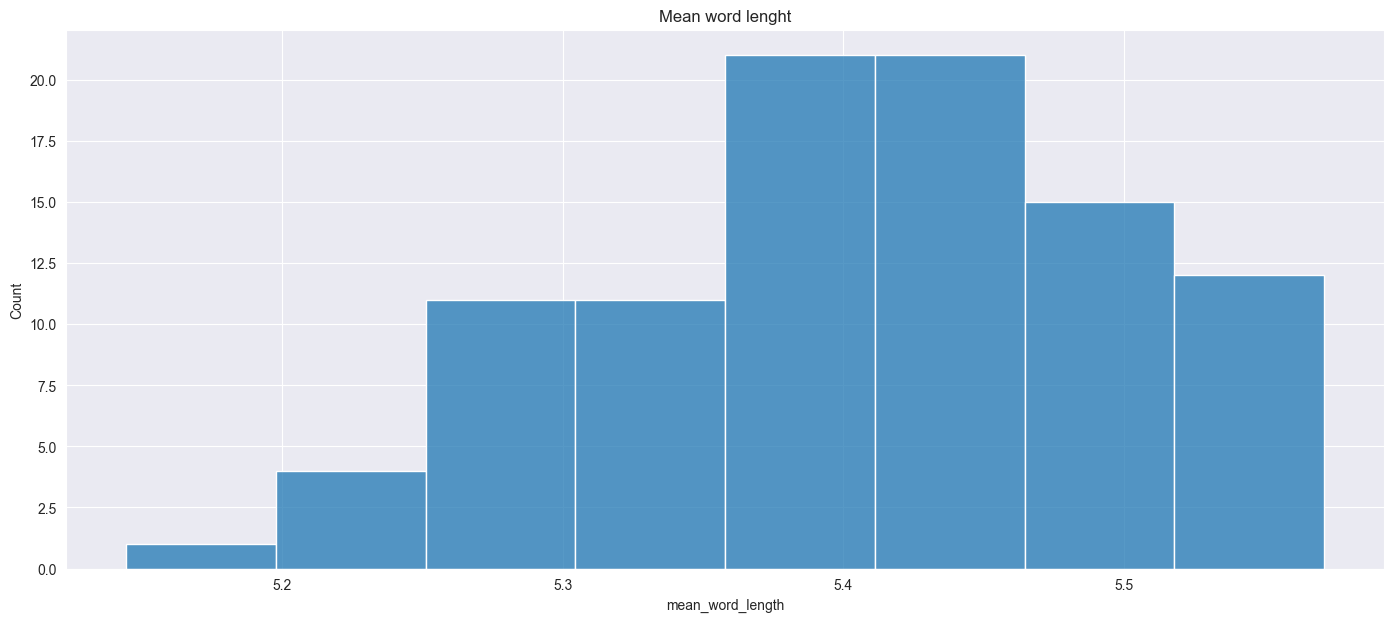

In [15]:
sns.histplot(X_val["mean_word_length"]).set(title='Mean word lenght')

In [16]:
X_val["sentence_count"] = X_val["text"].map(lambda rev: len(sent_tokenize(rev)))

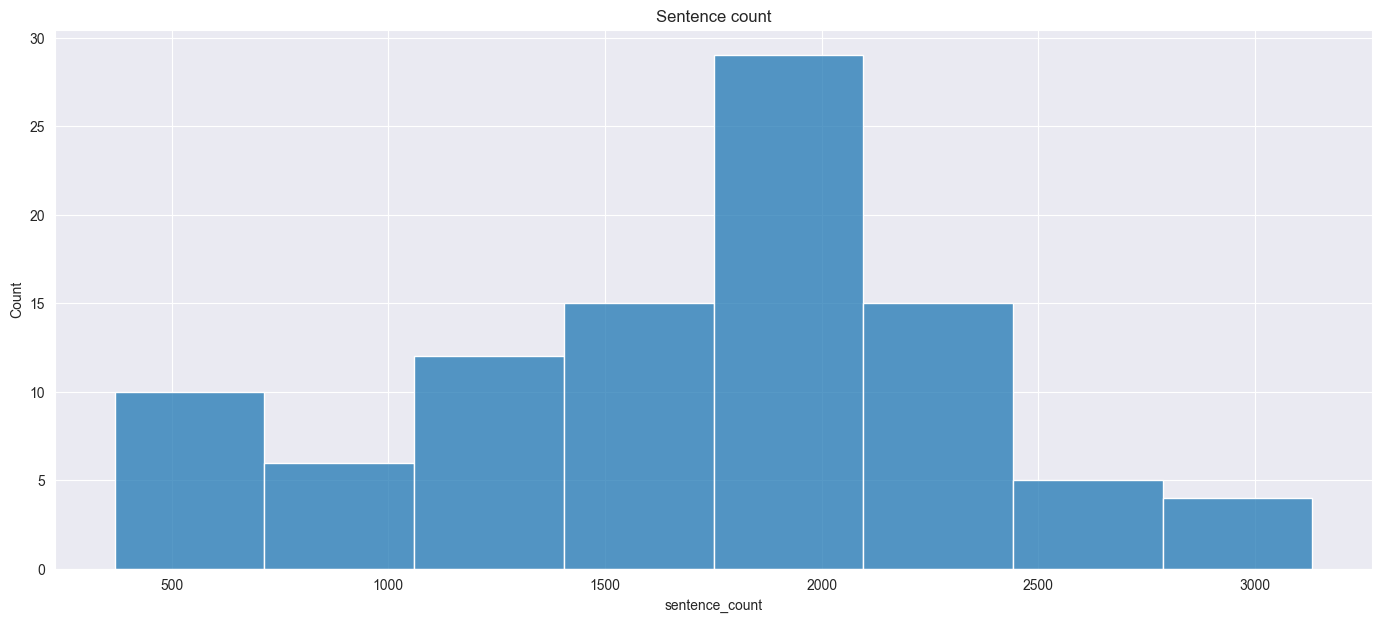

In [17]:
sns.histplot(X_val["sentence_count"]).set(title='Sentence count');

In [18]:
X_val["mean_sentence_length"] = X_val["text"].map(lambda rev: np.mean([len(sent) for sent in sent_tokenize(rev)]))

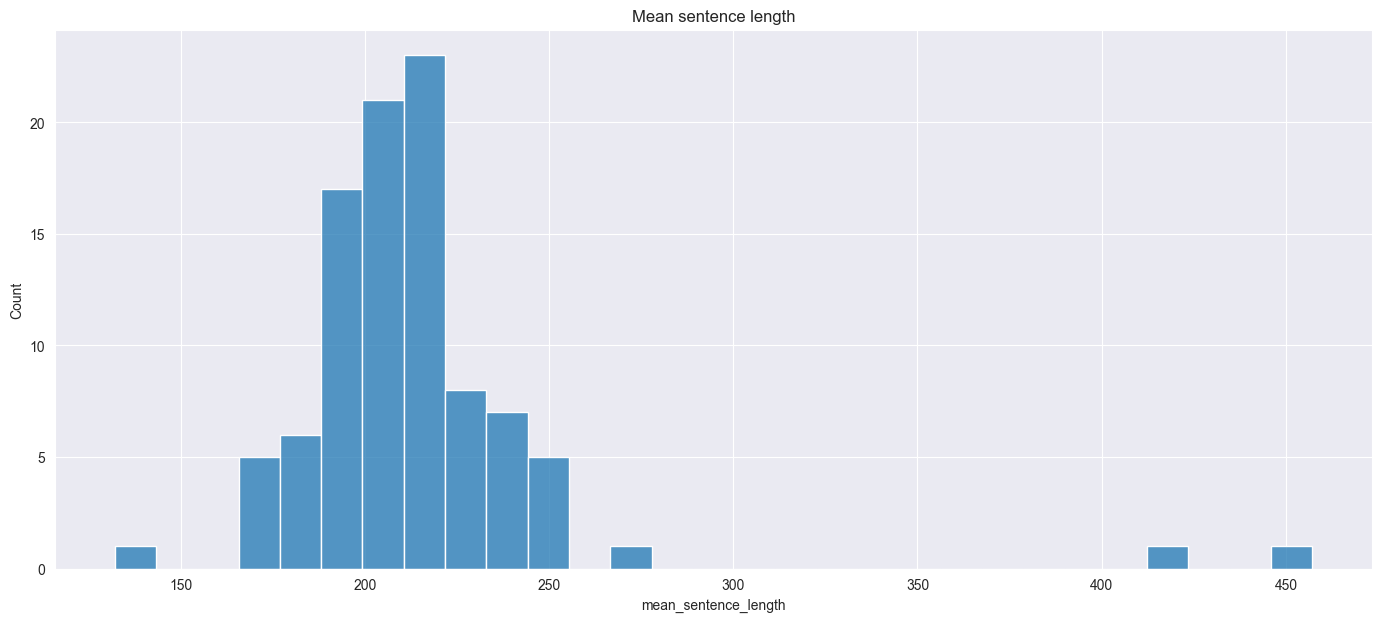

In [19]:
sns.histplot(X_val["mean_sentence_length"]).set(title='Mean sentence length');

In [20]:
X_val

,text,label,length,word_count,mean_word_length,sentence_count,mean_sentence_length
0,UNITED STATES SECURITIES AND EXCHANGE COMMISS...,pharma,474030,72965,5.496649,2232,211.411738
1,Table of Contents UNITED STATES SECURITIES AN...,pharma,354670,54824,5.469211,1802,195.820200
2,\t \t UNITED STATES SECURITIES AND EXCHANGE C...,pharma,252830,39102,5.465705,1309,192.145149
3,Use these links to rapidly review the documen...,pharma,405804,61985,5.546777,2012,200.692843
4,UNITED STATES SECURITIES AND EXCHANGE COMMISS...,pharma,107260,16682,5.429565,625,170.614400
...,...,...,...,...,...,...,...
91,Use these links to rapidly review the documen...,banks,555462,86062,5.454184,2292,241.347731
92,Table of Contents UNITED STATES SECURITIES AN...,banks,467334,73362,5.370219,2325,200.003441
93,Table of Contents UNITED STATES SECURITIES AN...,banks,430698,67629,5.368511,1715,250.135277
94,UNITED STATES SECURITIES AND EXCHANGE COMMISS...,banks,399561,62149,5.429050,1886,210.855779


In [21]:
def visualize(col):
    
    print()
    plt.subplot(1,2,1)
    sns.boxplot(y=X_val[col], hue=X_val['label'])
    plt.ylabel(col, labelpad=12.5)
    
    plt.subplot(1,2,2)
    sns.kdeplot(data=X_val, x=col, hue=X_val['label'])
    plt.legend(X_val['label'].unique())
    plt.xlabel('')
    plt.ylabel('')
    
    plt.show()

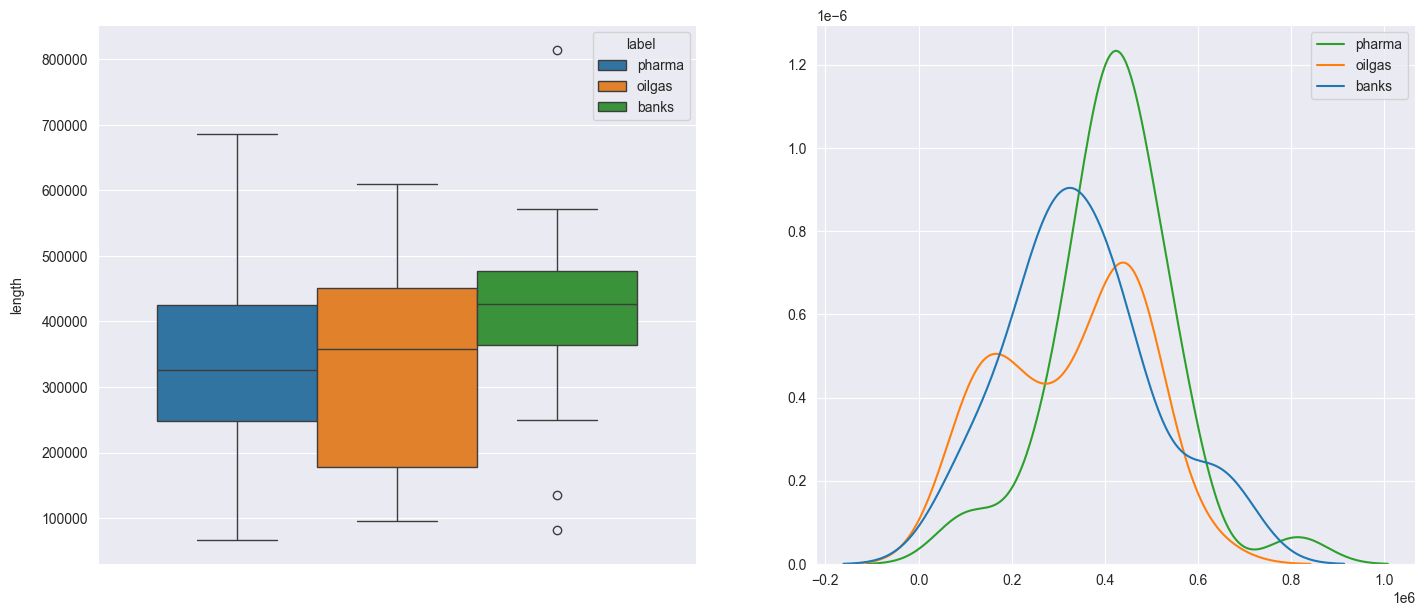

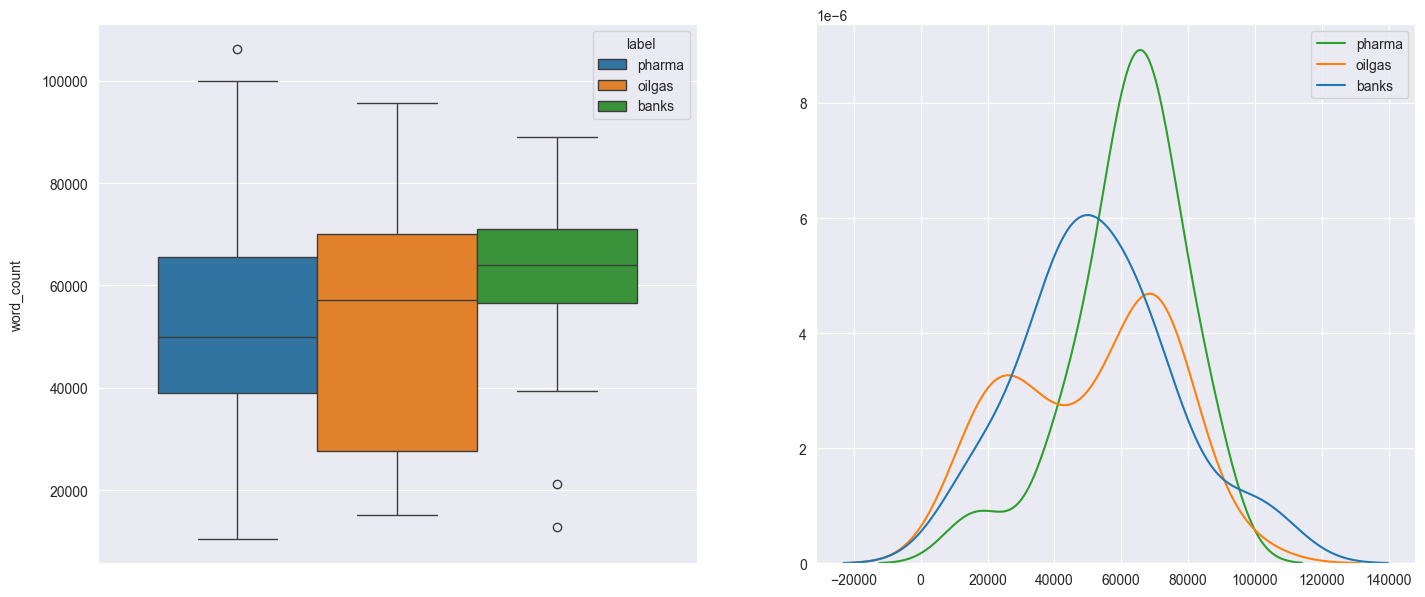

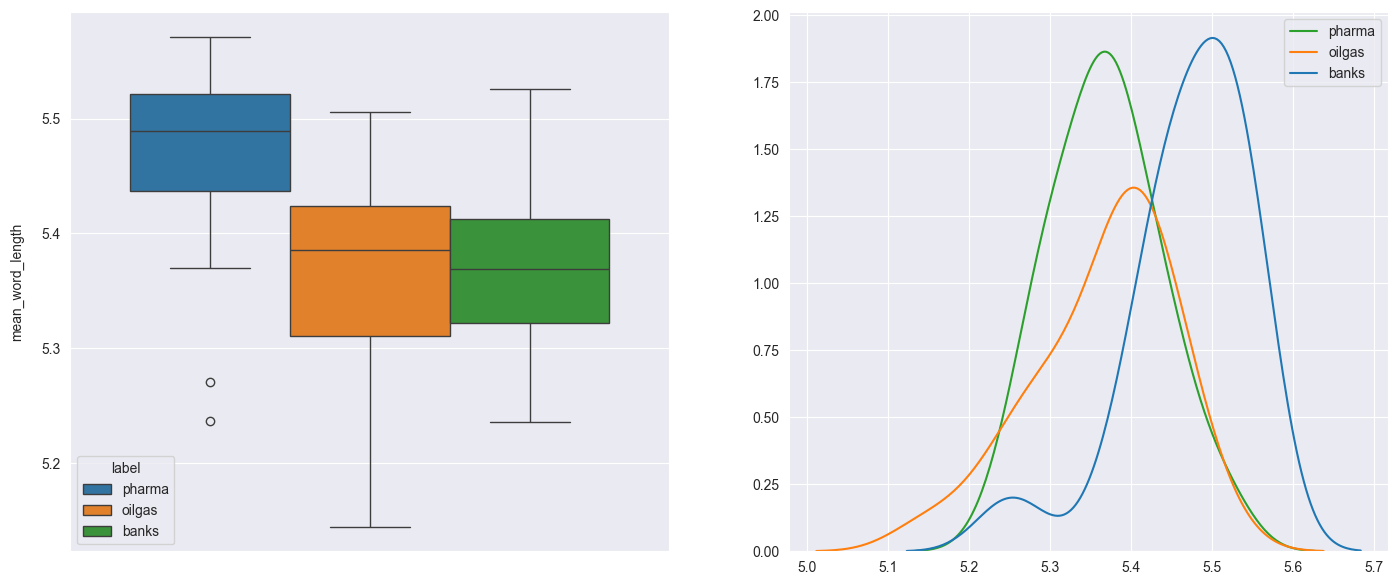

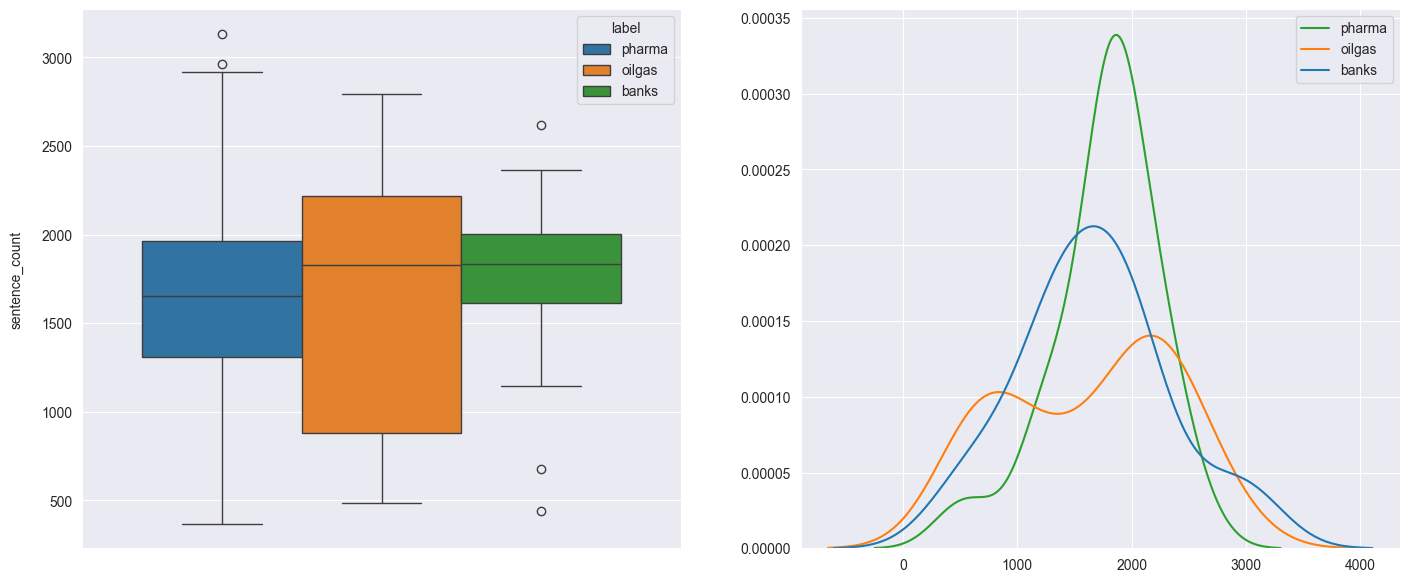

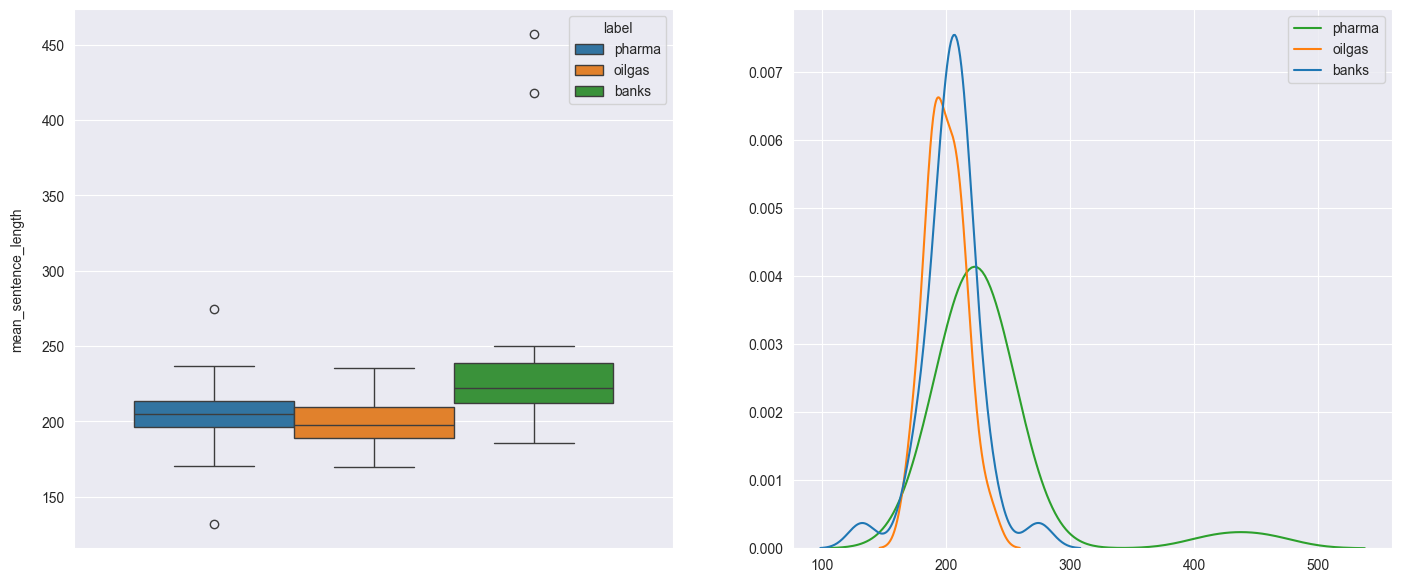

In [22]:
features = X_val.columns.tolist()[2:]
for feature in features:
    visualize(feature)

### Stopword Analysis

In [23]:
stop = set(stopwords.words('english'))

In [24]:
corpus=[]
texts = X_val["text"].str.split()
texts = texts.values.tolist()
corpus = [word for i in texts for word in i]

stopwords_dict = defaultdict(int)
for word in corpus:
    if word in stop:
        stopwords_dict[word]+=1

In [25]:
top_10_stopwords = sorted(stopwords_dict.items(), key=lambda x: x[1], reverse=True)[:10]

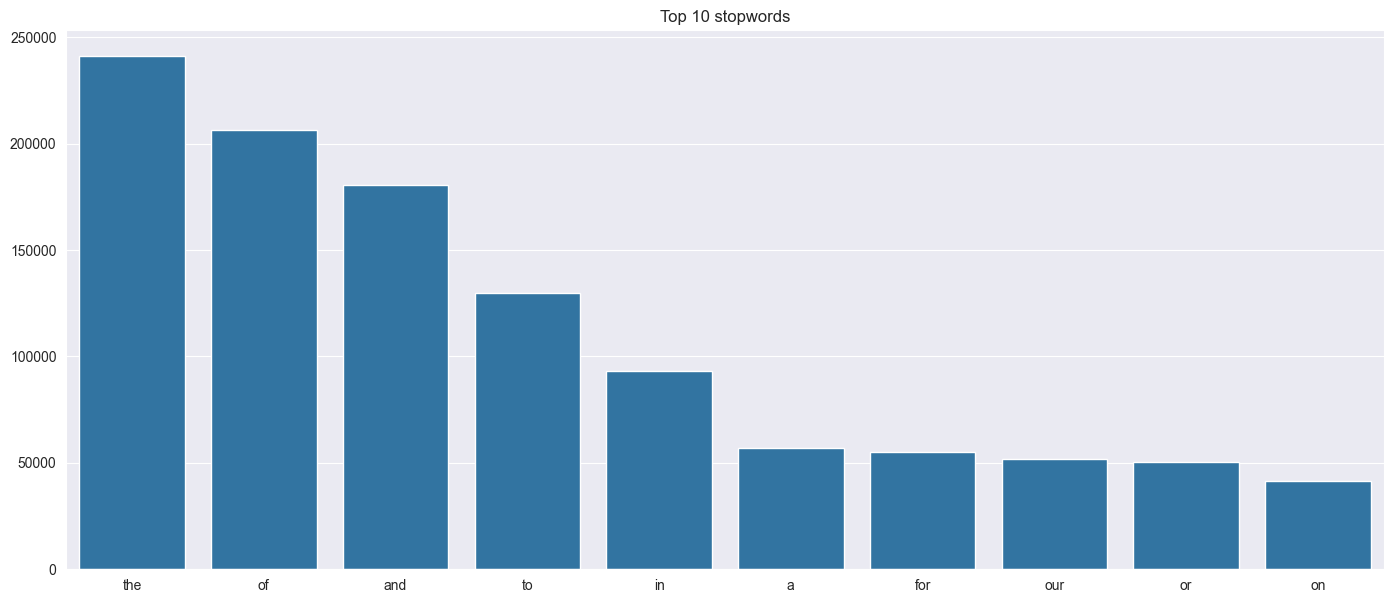

In [26]:
sns.barplot(dict(top_10_stopwords)).set(title='Top 10 stopwords');

### Frequently Occuring Words

In [27]:
X_val

,text,label,length,word_count,mean_word_length,sentence_count,mean_sentence_length
0,UNITED STATES SECURITIES AND EXCHANGE COMMISS...,pharma,474030,72965,5.496649,2232,211.411738
1,Table of Contents UNITED STATES SECURITIES AN...,pharma,354670,54824,5.469211,1802,195.820200
2,\t \t UNITED STATES SECURITIES AND EXCHANGE C...,pharma,252830,39102,5.465705,1309,192.145149
3,Use these links to rapidly review the documen...,pharma,405804,61985,5.546777,2012,200.692843
4,UNITED STATES SECURITIES AND EXCHANGE COMMISS...,pharma,107260,16682,5.429565,625,170.614400
...,...,...,...,...,...,...,...
91,Use these links to rapidly review the documen...,banks,555462,86062,5.454184,2292,241.347731
92,Table of Contents UNITED STATES SECURITIES AN...,banks,467334,73362,5.370219,2325,200.003441
93,Table of Contents UNITED STATES SECURITIES AN...,banks,430698,67629,5.368511,1715,250.135277
94,UNITED STATES SECURITIES AND EXCHANGE COMMISS...,banks,399561,62149,5.429050,1886,210.855779


In [28]:
def clean(review):
    
    review = review.lower()  # to lowercase
    review = re.sub('[^a-zA-Z ]+', '', review)  # delete punctuation 
    review = " ".join([word for word in review.split() if word not in stop])  # remove stopwords
    
    return review

In [29]:
X_val["clean_text"] = X_val["text"].map(clean)

In [30]:
texts = X_val["clean_text"].str.split().values.tolist()
corpus_without_stopwords = [word for words in texts for word in words]

In [31]:
most_common_in_train = dict(Counter(corpus_without_stopwords).most_common(10))

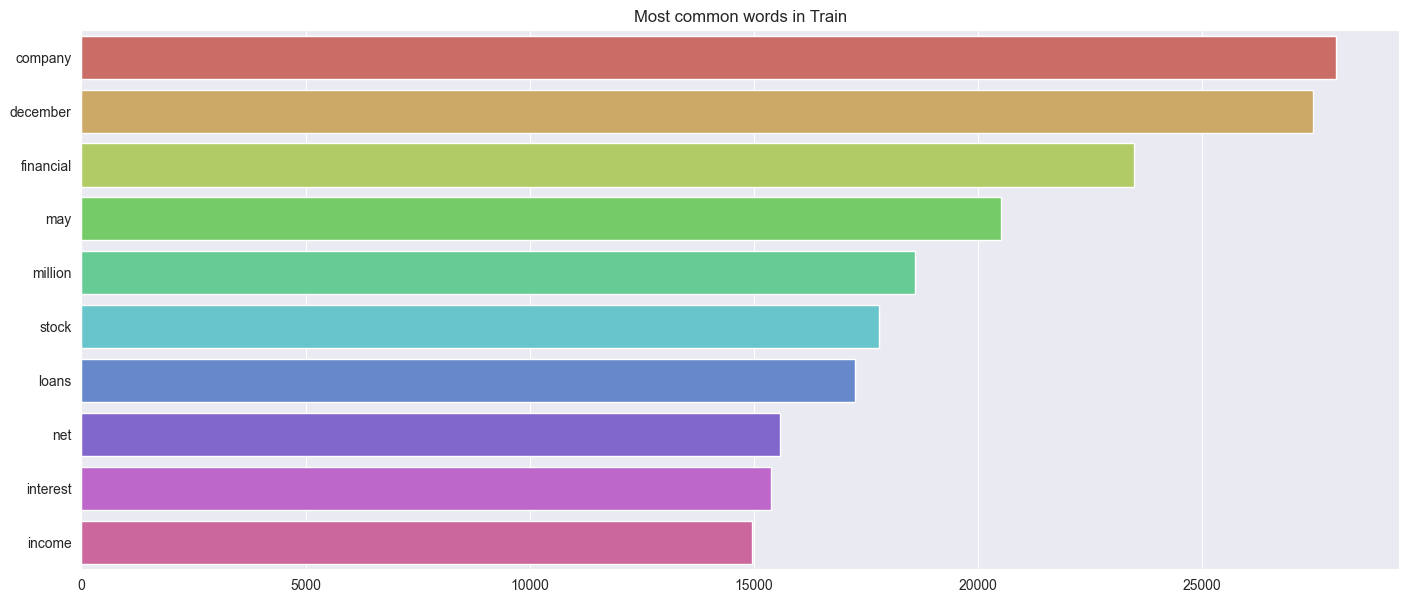

In [32]:
sns.barplot(x=most_common_in_train.values(), y=most_common_in_train.keys(), palette="hls").set_title("Most common words in Train");

In [33]:
def get_most_common(column, n: int = 10):
    texts = column.str.split().values.tolist()
    corpus = [word for words in texts for word in words]
    most_common = dict(Counter(corpus).most_common(n))
    return most_common

In [34]:
oilgas_most_common = get_most_common(X_val[X_val.label == "oilgas"]["clean_text"])

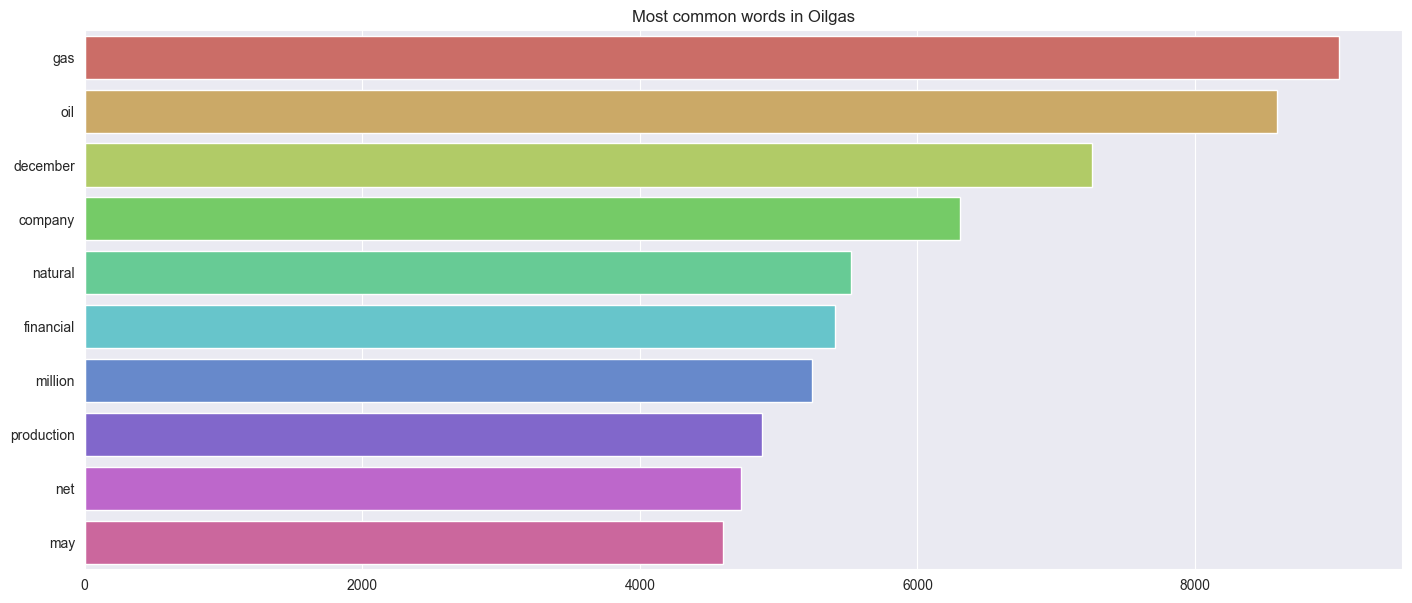

In [35]:
sns.barplot(x=oilgas_most_common.values(), y=oilgas_most_common.keys(), palette="hls").set_title("Most common words in Oilgas");

In [36]:
pharma_most_common = get_most_common(X_val[X_val.label == "pharma"]["clean_text"])

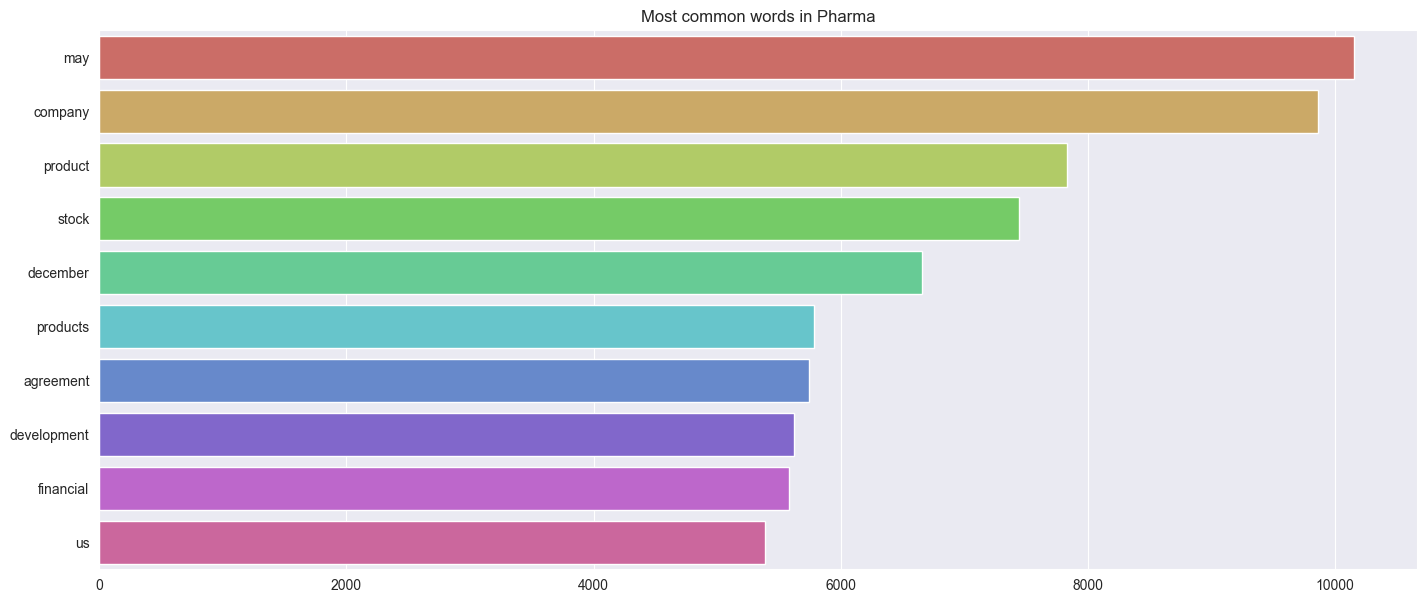

In [37]:
sns.barplot(x=pharma_most_common.values(), y=pharma_most_common.keys(), palette="hls").set_title("Most common words in Pharma");

In [38]:
banks_most_common = get_most_common(X_val[X_val.label == "banks"]["clean_text"])

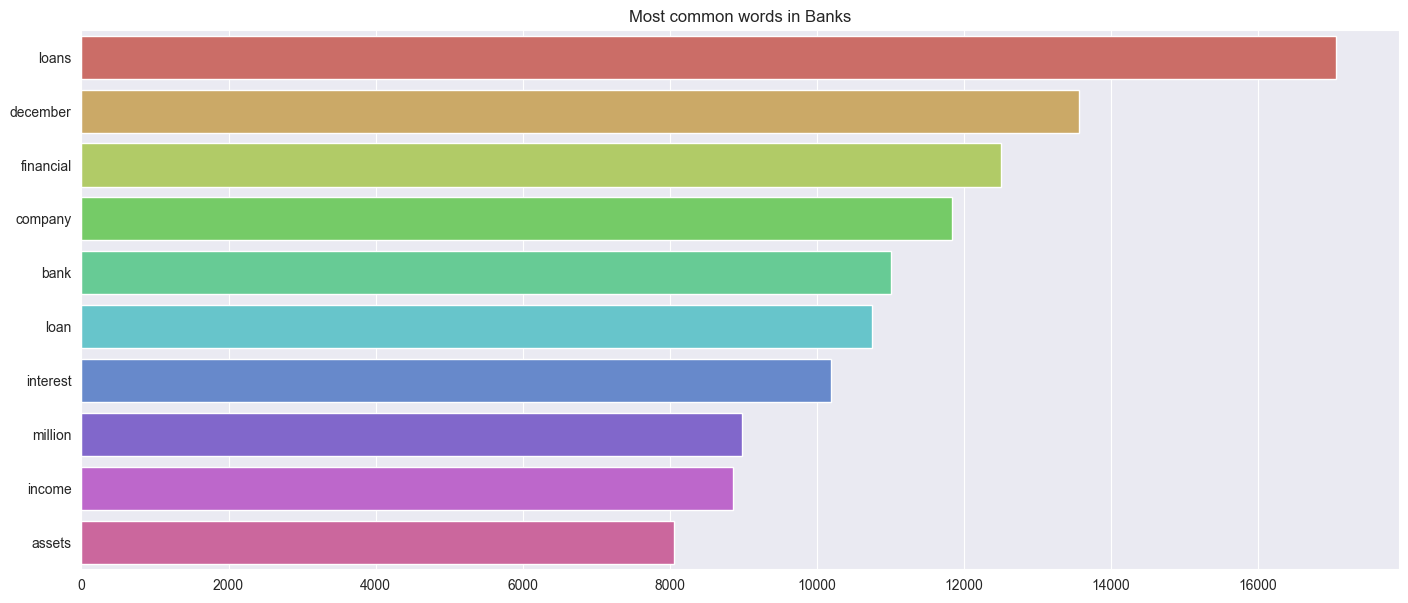

In [39]:
sns.barplot(x=banks_most_common.values(), y=banks_most_common.keys(), palette="hls").set_title("Most common words in Banks");

In [40]:
oilgas_keys = set(oilgas_most_common.keys())
pharma_keys = set(pharma_most_common.keys())
banks_keys = set(banks_most_common.keys())

unique_in_oilgas = oilgas_keys - pharma_keys - banks_keys
unique_in_pharma = pharma_keys - oilgas_keys - banks_keys
unique_in_banks =banks_keys - oilgas_keys - pharma_keys

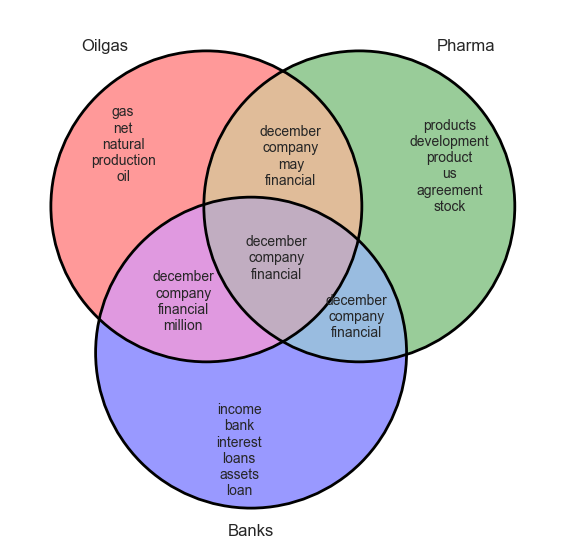

In [41]:
venn = venn3([oilgas_keys, pharma_keys, banks_keys], ('Oilgas', 'Pharma', 'Banks'))

venn.get_label_by_id('100').set_text('\n'.join(unique_in_oilgas))
venn.get_label_by_id('010').set_text('\n'.join(unique_in_pharma))
venn.get_label_by_id('001').set_text('\n'.join(unique_in_banks))
venn.get_label_by_id('110').set_text('\n'.join(oilgas_keys & pharma_keys))
venn.get_label_by_id('101').set_text('\n'.join(oilgas_keys & banks_keys))
venn.get_label_by_id('011').set_text('\n'.join(pharma_keys & banks_keys))
venn.get_label_by_id('111').set_text('\n'.join(oilgas_keys & pharma_keys & banks_keys))


for text in venn.set_labels:
    text.set_fontsize(12)
for text in venn.subset_labels:
    text.set_fontsize(10)

venn3_circles([oilgas_keys, pharma_keys, banks_keys]);

#### Create features for most common words in class

In [42]:
def count_terms(text, terms):
    return sum(word in terms for word in text.split())

In [43]:
X_val["bank_terms_count"] = X_val["clean_text"].apply(lambda x: count_terms(x, unique_in_banks))

In [44]:
X_val["pharma_terms_count"] = X_val["clean_text"].apply(lambda x: count_terms(x, unique_in_pharma))

In [45]:
X_val["oilgas_terms_count"] = X_val["clean_text"].apply(lambda x: count_terms(x, unique_in_oilgas))

### Most Frequently occuring N-grams

In [46]:
def get_top_ngram(corpus, n=None, top=10):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    ngram_freq = pd.DataFrame(sorted(words_freq, key = lambda x: x[1], reverse=True))
    ngram_freq.columns = ["ngram", "frequency"]
    return ngram_freq[:top]

In [47]:
bigram_freq_text = get_top_ngram(X_val["text"], n=2)

In [48]:
bigram_freq_clean_text = get_top_ngram(X_val["clean_text"], n=2)

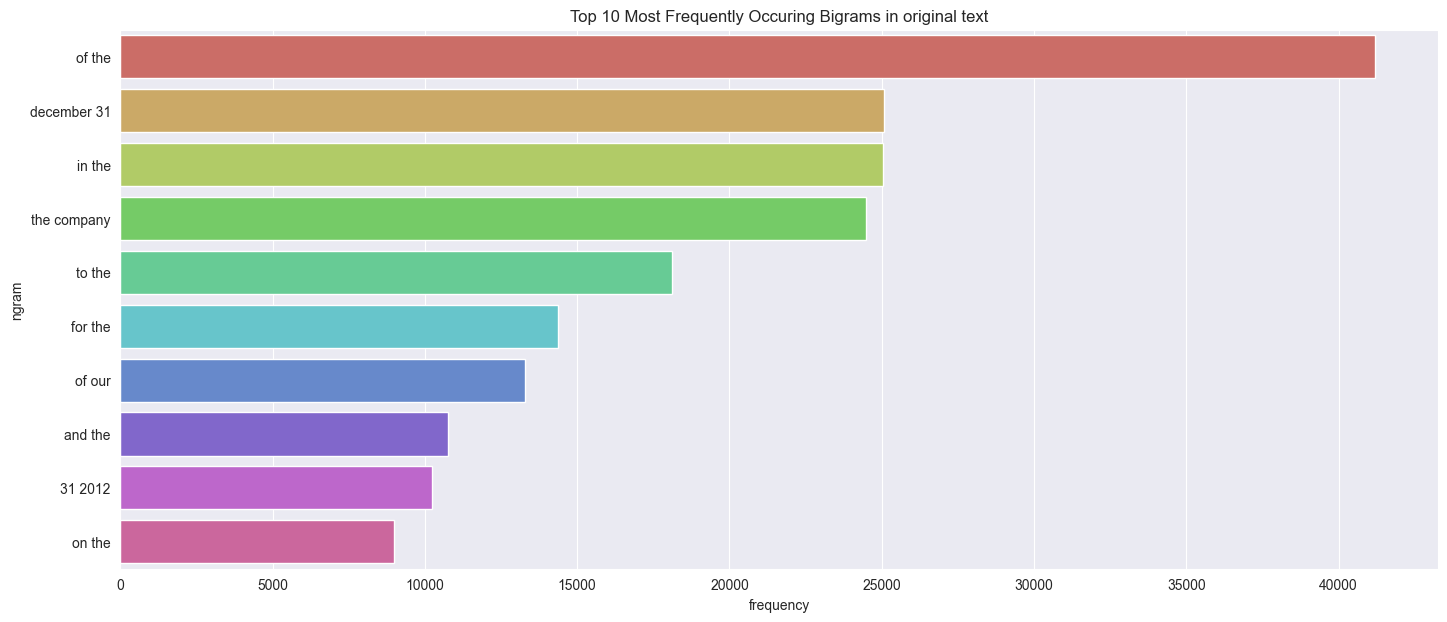

In [49]:
sns.barplot(x=bigram_freq_text['frequency'], y=bigram_freq_text['ngram'], palette="hls")
plt.title('Top 10 Most Frequently Occuring Bigrams in original text')
plt.show()

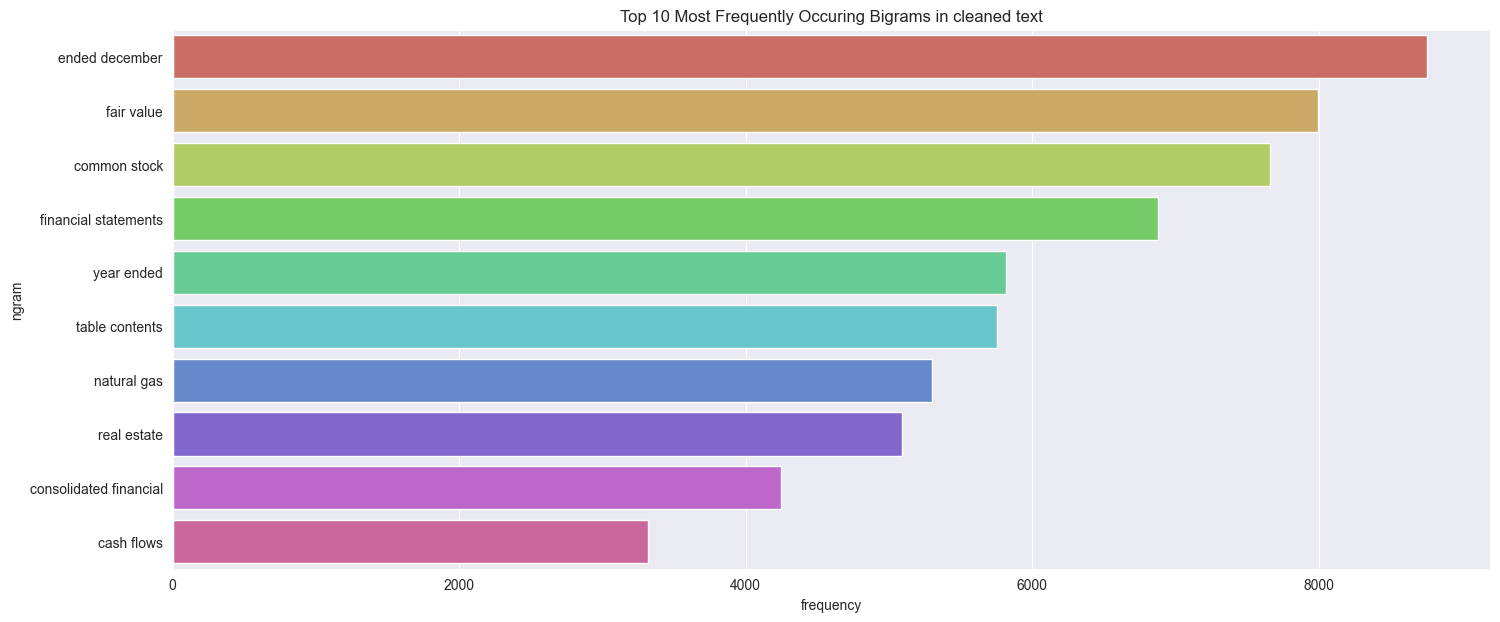

In [50]:
sns.barplot(x=bigram_freq_clean_text['frequency'], y=bigram_freq_clean_text['ngram'], palette="hls")
plt.title('Top 10 Most Frequently Occuring Bigrams in cleaned text')
plt.show()

In [51]:
trigram_freq_text = get_top_ngram(X_val["text"], n=3)

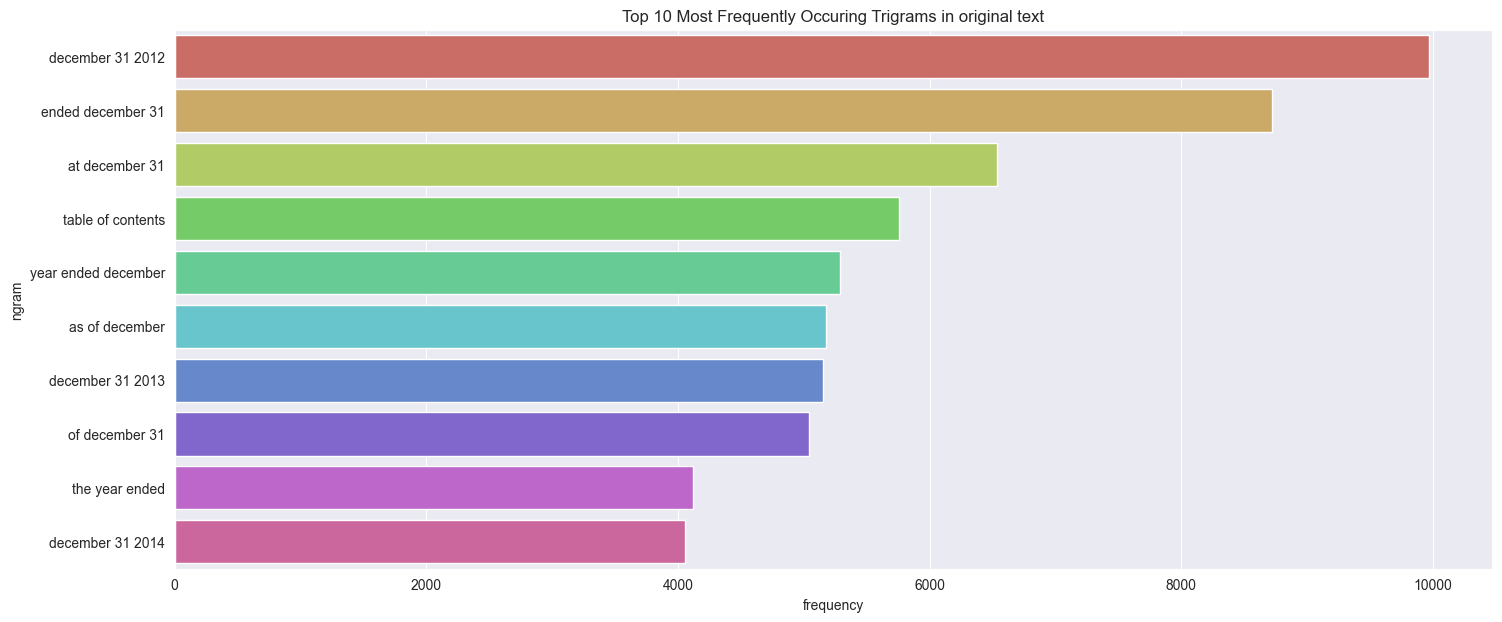

In [52]:
sns.barplot(x=trigram_freq_text['frequency'], y=trigram_freq_text['ngram'], palette="hls")
plt.title('Top 10 Most Frequently Occuring Trigrams in original text')
plt.show()

In [53]:
trigram_freq_clean_text = get_top_ngram(X_val["clean_text"], n=3)

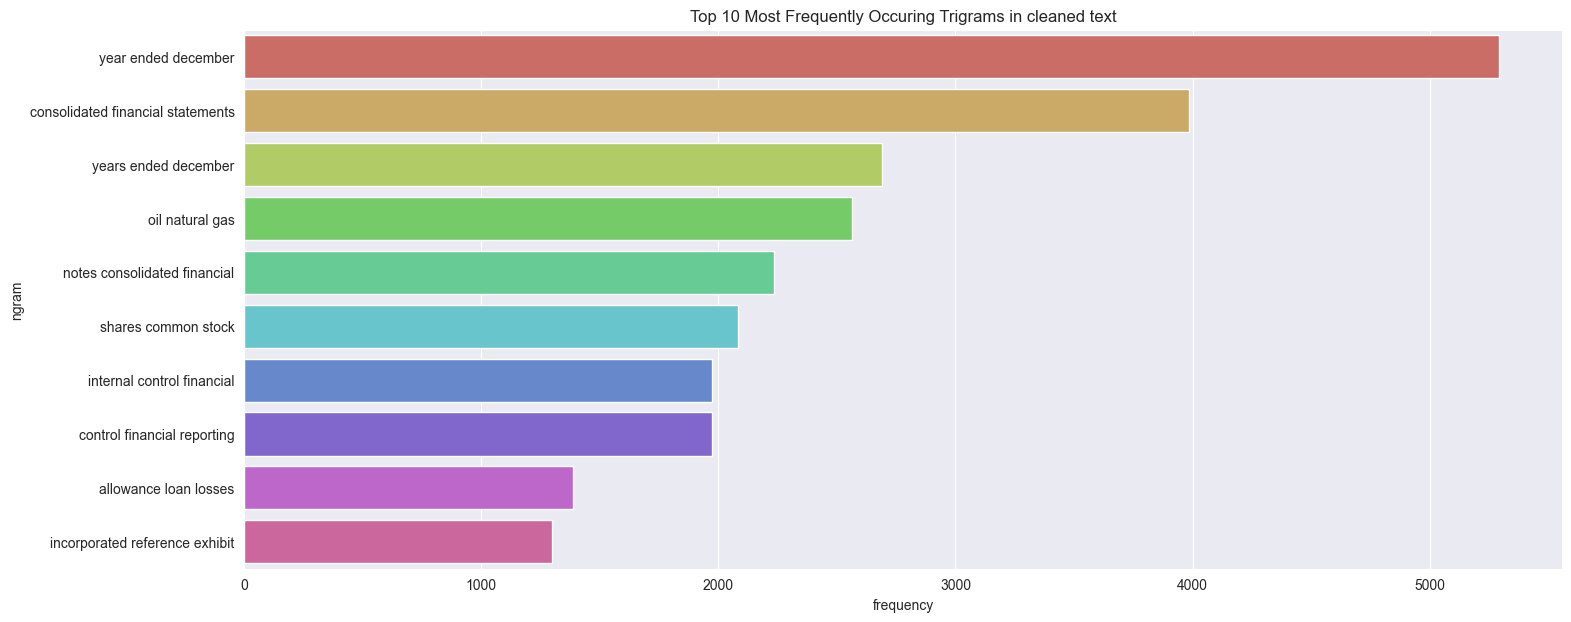

In [54]:
sns.barplot(x=trigram_freq_clean_text['frequency'], y=trigram_freq_clean_text['ngram'], palette="hls")
plt.title('Top 10 Most Frequently Occuring Trigrams in cleaned text')
plt.show()

## TF-IDF

#### Некоторые параметры: 
* input : string {‘filename’, ‘file’, ‘content’}
*  lowercase : boolean, default True
*  preprocessor : callable or None (default)
*  tokenizer : callable or None (default)
*  stop_words : string {‘english’}, list, or None (default)
*  ngram_range : tuple (min_n, max_n)
*  max_df : float in range [0.0, 1.0] or int, default=1.0
*  min_df : float in range [0.0, 1.0] or int, default=1
*  max_features : int or None, default=None

In [55]:
X_val.label.value_counts()

label
pharma    34
banks     34
oilgas    28
Name: count, dtype: int64

In [83]:
import en_core_web_sm
nlp = en_core_web_sm.load()

def lemmatize_text(text):
    spacy_results = nlp(text)
    return ' '.join([token.lemma_ for token in spacy_results])

In [85]:
X_val["lemmatized_text"] = X_val["clean_text"].map(lemmatize_text)

In [90]:
X_val.to_csv("processed_train.csv", index=False)

In [29]:
X_val = pd.read_csv("processed_train.csv")

In [30]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=0.01, max_df=0.8, max_features=10000)
vectors = vectorizer.fit_transform(X_val["lemmatized_text"])
vectors.shape

(96, 10000)

```python 
# batch preprocess
%%time

new_texts = []
texts = train["clean_text"].copy()
nlp = en_core_web_trf.load()
for doc in nlp.pipe(texts, batch_size=32, n_process=3, disable=["parser", "ner"]):  
    new_texts.append(' '.join([tok.lemma_ for tok in doc if tok.lemma_ not in stopWords]))
```

In [31]:
dense_vectors = vectors.todense()
dense_vectors.shape

(96, 10000)

In [32]:
vector = vectors.todense()[0]
(vector != 0).sum(), vector.shape

(4070, (1, 10000))

In [33]:
np.mean(list(map(lambda x: (x != 0).sum(), vectors.todense())))

3693.28125

In [34]:
vectorizer.get_feature_names_out()[:10]

array(['aa', 'ab', 'abandon', 'abandonment', 'abbott', 'abbreviate',
       'abi', 'ability access', 'ability attract',
       'ability attract retain'], dtype=object)

In [109]:
def cosine_similarity(v1, v2):
    return np.array(v1 @ v2.T / norm(v1) / norm(v2))[0][0]

In [114]:
for i in range(10):
    print(cosine_similarity(dense_vectors[0], dense_vectors[-i]))

1.0000000000000002
0.008539534612409333
0.01910062555676617
0.02631550019679152
0.039392457902422066
0.021335228976858547
0.018738408532137978
0.025728685744903973
0.021943888907706256
0.0061125347378477805


### Train model

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.linear_model import SGDClassifier

In [36]:
X_train, X_test, y_train, y_test= train_test_split(dense_vectors, X_val.label.values, 
                                                   test_size=0.2, random_state=26, 
                                                   shuffle=True, stratify=X_val.label.values)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((76, 10000), (76,), (20, 10000), (20,))

In [37]:
%%time
svc = svm.SVC()
svc.fit(np.asarray(X_train), y_train)

CPU times: user 30.2 ms, sys: 0 ns, total: 30.2 ms
Wall time: 28.8 ms


SVC()

In [38]:
accuracy_score(y_test, svc.predict(np.asarray(X_test)))

1.0

In [47]:
precision_score(y_test, svc.predict(np.asarray(X_test)), average="micro")

1.0

In [48]:
recall_score(y_test, svc.predict(np.asarray(X_test)), average="micro")

1.0

In [50]:
f1_score(y_test, svc.predict(np.asarray(X_test)), average="micro")

1.0

In [44]:
sgd = SGDClassifier()
sgd.fit(np.asarray(X_train), y_train)
accuracy_score(y_test, sgd.predict(np.asarray(X_test)))

1.0

In [51]:
from sklearn.metrics import confusion_matrix,classification_report

In [53]:
print(classification_report(y_test, svc.predict(np.asarray(X_test))))

              precision    recall  f1-score   support

       banks       1.00      1.00      1.00         7
      oilgas       1.00      1.00      1.00         6
      pharma       1.00      1.00      1.00         7

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [54]:
svc.predict(np.asarray(X_test))

array(['oilgas', 'banks', 'banks', 'pharma', 'banks', 'oilgas', 'pharma',
       'banks', 'oilgas', 'pharma', 'banks', 'oilgas', 'oilgas', 'oilgas',
       'pharma', 'pharma', 'pharma', 'banks', 'pharma', 'banks'],
      dtype=object)

In [ ]:
with open("text.txt", w) as fin:
    

In [2]:
import os
import random
import re
from glob import glob

import en_core_web_sm
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from tqdm import tqdm


def clean_text(review, stopwords):
    review = review.lower()  # to lowercase
    review = re.sub("[^a-zA-Z ]+", "", review)  # delete punctuation
    review = " ".join([word for word in review.split() if word not in stopwords])

    return review


def lemmatize_text(text, lemmatizer):
    spacy_results = lemmatizer(text)
    return " ".join([token.lemma_ for token in spacy_results])


def preprocess_text(
    path_to_folder: str,
    stopwords,
    lemmatizer,
    pattern: str = "**/*.txt",
    test: bool = False,
    shuffle: bool = False,
):
    preprocessed_texts, labels = [], []
    if test:
        pattern = "*.txt"
        
    paths = glob(os.path.join(path_to_folder, pattern))
    
    if shuffle:
        random.shuffle(paths)
    for path in tqdm(paths):
        with open(path, "r") as file:
            text = file.readline().strip()
            cleaned_text = clean_text(text, stopwords)
            lemmatized_text = lemmatize_text(cleaned_text, lemmatizer)
            preprocessed_texts.append(lemmatized_text)

        if not test:
            label = os.path.basename(os.path.dirname(path))
            labels.append(label)

    return (preprocessed_texts, labels) if not test else preprocessed_texts


def train_linear_classifier(
    X_train,
    y_train,
    ngram_range: tuple = (1, 3),
    min_df: float = 0.01,
    max_df: float = 0.8,
    max_features: int = 10000,
):
    vectorizer = TfidfVectorizer(
        ngram_range=ngram_range, min_df=min_df, max_df=max_df, max_features=max_features
    )
    vectors = vectorizer.fit_transform(X_train)
    dense_vectors = vectors.todense()

    svc = SVC()
    svc.fit(np.asarray(dense_vectors), y_train)
    return svc

def test_classifier(model, X_test):
    y_test = model.predict(np.asarray(X_test))
    return y_test


def save_predictions(predictions, output_path):
    with open(output_path, "w") as f:
        for item in predictions:
            f.write("%s\n" % item)



lemmatizer = en_core_web_sm.load()
stop = set(stopwords.words("english"))

# Step 1: Preprocessing data
print("Step 1: Preprocessing data")
X_train, y_train = preprocess_text(
    path_to_folder="/home/akeresh/Desktop/kbtu/kbtu-nlp-2024/HW1/data/train",
    stopwords=stop,
    lemmatizer=lemmatizer,
    shuffle=True,
)
X_val, y_val = preprocess_text(
    path_to_folder="/home/akeresh/Desktop/kbtu/kbtu-nlp-2024/HW1/data/validat",
    stopwords=stop,
    lemmatizer=lemmatizer,
)
X_test = preprocess_text(
    path_to_folder="/home/akeresh/Desktop/kbtu/kbtu-nlp-2024/HW1/data/test",
    stopwords=stop,
    lemmatizer=lemmatizer,
    test=True,
)

Step 1: Preprocessing data


100%|██████████| 18/18 [01:09<00:00,  3.88s/it]


In [5]:
pd.DataFrame({"text": X_test}).to_csv("test_lemmatization_text.csv", index=False)

In [8]:
pd.DataFrame({"text": X_train, "label": y_train}).to_csv("train_lemmatization_text.csv", index=False)

In [9]:
pd.DataFrame({"text": X_val, "label": y_val}).to_csv("val_lemmatization_text.csv", index=False)

In [25]:
X_train = pd.read_csv("train_lemmatization_text.csv")
X_test = pd.read_csv("test_lemmatization_text.csv")
X_val = pd.read_csv("val_lemmatization_text.csv")

In [31]:
vectorizer = TfidfVectorizer(
        ngram_range=(1, 3), min_df=0.01, max_df=0.8, max_features=10000
    )
X_train_features = vectorizer.fit_transform(X_train["text"]).todense()
X_val_features = vectorizer.transform(X_val["text"]).todense()
X_test_features = vectorizer.transform(X_test["text"]).todense()

In [54]:
X_train.rename(columns={"clean_text": "lemmatized_text"}, inplace=True)

In [56]:
X_train_full_merged =  pd.merge(X_train, X_train_full, on="lemmatized_text")

In [32]:
X_train_features.shape

(96, 10000)

In [35]:
X_train_full = pd.read_csv("processed_train.csv")

In [37]:
X_train_full.columns

Index(['text', 'label', 'length', 'word_count', 'mean_word_length',
       'sentence_count', 'mean_sentence_length', 'clean_text',
       'bank_terms_count', 'pharma_terms_count', 'oilgas_terms_count',
       'lemmatized_text'],
      dtype='object')

In [59]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

numerical_features = ['length', 'word_count', 'mean_word_length',
       'sentence_count', 'mean_sentence_length',
       'bank_terms_count', 'pharma_terms_count', 'oilgas_terms_count']  # update with your actual features

# Create transformers for categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
    ])

# Fit and transform the additional features
additional_features = preprocessor.fit_transform(X_train_full_merged)

In [61]:
import scipy.sparse

In [64]:
# Assuming text_features is a sparse matrix and additional_features is a dense matrix
# Convert additional_features to a sparse matrix
additional_features_sparse = scipy.sparse.csr_matrix(additional_features)

In [65]:
additional_features_sparse.shape

(96, 8)

In [42]:
X_train_features.shape

(96, 10000)

In [43]:
from scipy.sparse import hstack

In [66]:
combined_features = hstack([X_train_features, additional_features_sparse])

In [87]:
combined_features_array = combined_features.todense()

In [88]:
type(combined_features_array)

numpy.matrix

In [89]:
combined_features_array.shape

(96, 10008)

In [90]:
def train_linear_classifier(
    X_train,
    y_train,
):
    svc = SVC()
    svc.fit(np.asarray(X_train), y_train)
    return svc

In [92]:
type(combined_features_array)

numpy.matrix

In [93]:
type(X_train_features)

numpy.matrix

In [94]:
combined_features_array[0]

matrix([[ 0.00177694,  0.00208502,  0.        , ..., -0.68706683,
          1.17233574, -0.42894295]])

In [95]:
# Step 2: Training a linear classifier
print("Step 2: Training a linear classifier")
model_combined = train_linear_classifier(combined_features_array, y_train)

Step 2: Training a linear classifier


In [98]:
X_val

,text,label
0,table content united states securities exchang...,pharma
1,table content united states securities exchang...,pharma
2,united states securities exchange commission w...,pharma
3,united states securities exchange commission w...,pharma
4,united states securities exchange commission w...,pharma
5,table content united states securities exchang...,pharma
6,united states securities exchange commission w...,oilgas
7,united states securities exchange commission w...,oilgas
8,united states securities exchange commission w...,oilgas
9,united states securities exchange commission w...,oilgas


In [104]:
X_val["length"] = X_val["text"].str.len()
X_val["word_count"] = X_val["text"].str.split().str.len()
X_val['mean_word_length'] = X_val["text"].map(lambda rev: np.mean([len(word) for word in rev.split()]))
X_val["sentence_count"] = X_val["text"].map(lambda rev: len(sent_tokenize(rev)))
X_val["mean_sentence_length"] = X_val["text"].map(lambda rev: np.mean([len(sent) for sent in sent_tokenize(rev)]))

In [108]:
X_val_orig = pd.read_csv("val.csv")

In [111]:
lemmatizer = en_core_web_sm.load()

def lemmatize_text(text):
    spacy_results = lemmatizer(text)
    return " ".join([token.lemma_ for token in spacy_results])


In [115]:
X_val_orig["lemma_text"]  = X_val_orig["text"].map(lemmatize_text)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fd8c0466080>>
Traceback (most recent call last):
  File "/home/akeresh/anaconda3/envs/kbtu-nlp/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [106]:
X_val

,text,label,length,word_count,mean_word_length,sentence_count,mean_sentence_length
0,table content united states securities exchang...,pharma,230842,28834,7.005930,1,230842.0
1,table content united states securities exchang...,pharma,134608,17083,6.879705,1,134608.0
2,united states securities exchange commission w...,pharma,316159,39896,6.924604,1,316159.0
3,united states securities exchange commission w...,pharma,206492,26331,6.842201,1,206492.0
4,united states securities exchange commission w...,pharma,224729,29142,6.711550,1,224729.0
5,table content united states securities exchang...,pharma,140684,17965,6.831060,1,140684.0
6,united states securities exchange commission w...,oilgas,332052,42823,6.754081,1,332052.0
7,united states securities exchange commission w...,oilgas,39854,5076,6.851655,1,39854.0
8,united states securities exchange commission w...,oilgas,168929,21678,6.792693,1,168929.0
9,united states securities exchange commission w...,oilgas,167726,22057,6.604253,1,167726.0


In [ ]:
def get_most_common(column, n: int = 10):
    texts = column.str.split().values.tolist()
    corpus = [word for words in texts for word in words]
    most_common = dict(Counter(corpus).most_common(n))
    return most_common

In [97]:
print(classification_report(y_val, model_combined.predict(np.asarray(X_val_features))))

ValueError: X has 10000 features, but SVC is expecting 10008 features as input.

In [12]:
def train_linear_classifier(
    X_train,
    y_train,
):
    svc = SVC()
    svc.fit(np.asarray(X_train), y_train)
    return svc

In [13]:
# Step 2: Training a linear classifier
print("Step 2: Training a linear classifier")
model = train_linear_classifier(X_train, y_train)

Step 2: Training a linear classifier


In [15]:
print(classification_report(y_val, model.predict(np.asarray(X_val))))

              precision    recall  f1-score   support

       banks       1.00      1.00      1.00         6
      oilgas       1.00      0.83      0.91         6
      pharma       0.86      1.00      0.92         6

    accuracy                           0.94        18
   macro avg       0.95      0.94      0.94        18
weighted avg       0.95      0.94      0.94        18



In [14]:
def validate_classifier(model, X_val, y_val):
    print(classification_report(y_val, model.predict(np.asarray(X_val))))

In [16]:
# Step 3: Validate the model performance
print("Step 3: Validate the model performance")
validate_classifier(model, X_val, y_val)

Step 3: Validate the model performance
              precision    recall  f1-score   support

       banks       1.00      1.00      1.00         6
      oilgas       1.00      0.83      0.91         6
      pharma       0.86      1.00      0.92         6

    accuracy                           0.94        18
   macro avg       0.95      0.94      0.94        18
weighted avg       0.95      0.94      0.94        18



In [17]:
# Step 4: Test the model
print("Step 4: Test the model")
predictions = test_classifier(model, X_test)

Step 4: Test the model


In [18]:
predictions

array(['banks', 'oilgas', 'pharma', 'oilgas', 'banks', 'pharma', 'oilgas',
       'banks', 'pharma', 'oilgas', 'pharma', 'banks', 'banks', 'oilgas',
       'pharma', 'oilgas', 'banks', 'pharma'], dtype='<U6')

In [19]:

# Optional: Tune the model if validation results are not satisfactory



# Step 5: Save the predictions
print("Step 5: Save the predictions")
save_predictions(
    predictions, "/home/akeresh/Desktop/kbtu/kbtu-nlp-2024/HW1/data/predictions.txt"
)

Step 5: Save the predictions
